In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import tensorflow as tf
from scipy.stats import t
from scipy.stats import norm
from tensorflow.keras import backend as K

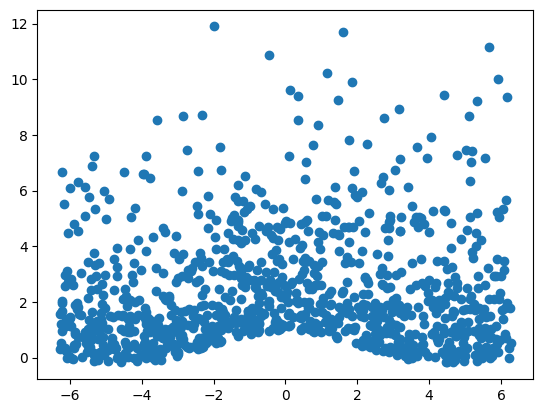

In [8]:
n_samples = 1000  # Example number of samples

# Generate noise from chi-square distribution with degree of freedom 2
noise = np.random.chisquare(df=2, size=n_samples)

# Generate X values uniformly
X = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=(n_samples, 1))

# Compute y values with the chi-square noise
y = (np.sin(X[:, 0]) / X[:, 0]) + noise
y_ = (np.sin(X[:, 0]) / X[:, 0])

# Prepare data for training
X_train = X.reshape(-1)
y_train = y.reshape(-1)
y_train = np.stack((y_train, y_train), axis=1)

# Create a grid for visualization
x_grid = np.linspace(-6, 6, 3000)
# plot the points
plt.scatter(X_train,y_train[:,0])

In [9]:
# hyperparameters for Tube Loss
q = 0.80 # target coverage
def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    # Use tf.where to create a tensor based on conditions
    loss_part1 = tf.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = tf.where(f1 > y_true, c3, c4)

    final_loss = tf.where(tf.logical_and(y_true <= f2, y_true >= f1), loss_part1, loss_part2) + (delta * tf.abs(f1 - f2))

    # Reduce the loss to a scalar using tf.reduce_mean
    return tf.reduce_mean(final_loss)

In [10]:
# set up model call the Tube loss with r=0.5
n_ = 40 # batch size
model = Sequential()
model.add(Dense(200, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))) # important to init biases to start!

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Use the Tube loss with r and delta parameter.
delta = 0
r = 0.5
loss=confidence_loss
model.compile(loss=loss, optimizer=opt)

# Train the ANN with Tube loss
result_loss=[]
result = model.fit(X_train, y_train, epochs=400, batch_size=n_, verbose=0,  validation_split=0.)


In [11]:
# Calculating Evaluation Criteria
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
print('PICP of Tube loss with r = 0.5:', np.mean(K_u * K_l))
print('MPIW PICP of Tube loss with r = 0.5:', np.round(np.mean(y_u_pred - y_l_pred),3))

PICP of Tube loss with r = 0.5: 0.796
MPIW PICP of Tube loss with r = 0.5: 6.296


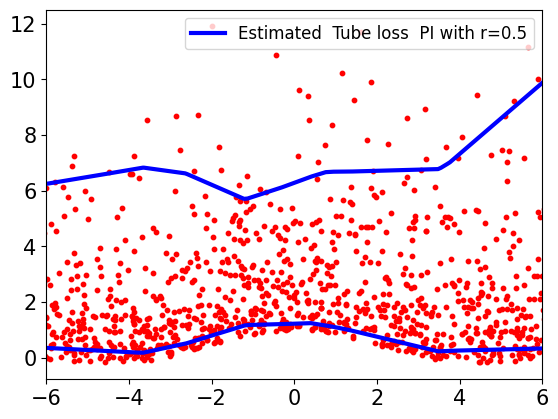

In [12]:
#Visualizing Final Result
plt.scatter(X_train,y_train[:,0],s=10,c='r')
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
plt.plot(x_grid, y_u_pred, color='b',linewidth=3,label='Estimated  Tube loss  PI with r=0.5') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='b',linewidth=3) # lower boundary prediction
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize="12",loc=1)
plt.xlim(-6,6)
plt.show()

In [13]:
#set up model call the Tube loss with r=0.1
n_ = 40 # batch size
model = Sequential()
model.add(Dense(200, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))) # important to init biases to start!

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Use the Tube loss with r and delta parameter.
delta = 0
r = 0.1
loss=confidence_loss
model.compile(loss=loss, optimizer=opt)

# Train the ANN with Tube loss
result_loss=[]
result = model.fit(X_train, y_train, epochs=400, batch_size=n_, verbose=0,  validation_split=0.)


In [14]:
# Calculating Evaluation Criteria
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
print('PICP of Tube loss with r = 0.1:', np.mean(K_u * K_l))
print('MPIW PICP of Tube loss with r = 0.1:', np.round(np.mean(y_u_pred - y_l_pred),3))

PICP of Tube loss with r = 0.1: 0.803
MPIW PICP of Tube loss with r = 0.1: 3.947


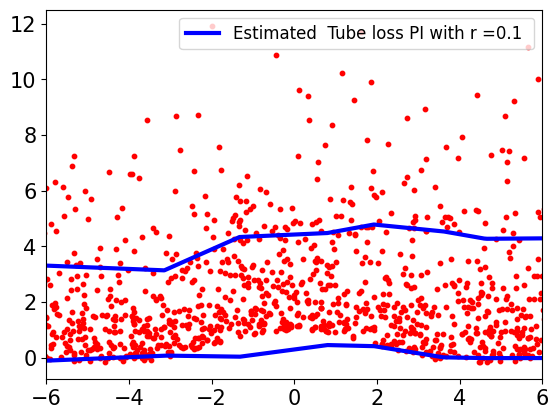

In [16]:
#Visualizing Final Result

plt.scatter(X_train,y_train[:,0],s=10,c='r')
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
plt.plot(x_grid, y_u_pred, color='b',linewidth=3,label='Estimated  Tube loss PI with r =0.1 ') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='b',linewidth=3) # lower boundary prediction
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize="12",loc=1)
plt.xlim(-6,6)
plt.show()